Name: Haris Azeem Yar Khan

SUID: 595786009

## Medical Insurance Analysis
This ML based analysis uses a medical insurance dataset with the following columns:
- **age**: Age of primary beneficiary
- **sex**: Female/Male
- **bmi**: Body mass index, providing an understanding of body weight relative to height, objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9
- **children**: Number of children covered by health insurance / Number of dependents
- **smoker**: Is a smoker — yes/no
- **region**: The beneficiary's residential area in the US — northeast, southeast, southwest, northwest.
- **charges**: Individual medical costs billed by health insurance

## Setup

In [ ]:
! pip install pyspark -q

In [ ]:
# download the insurance data set
%%bash
if [[ ! -f insurance.csv ]]; then
 wget https://syr-bda.s3.us-east-2.amazonaws.com/insurance.csv -q
fi

In [ ]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext.getOrCreate()

spark = SparkSession\
    .builder\
    .appName('Homework 03')\
    .getOrCreate()

## Data Exploration

Read the data into a Spark DataFrame named `insurance`. Column names should be age, sex, bmi, children, smoker, region, and charges. Print the resulting DataFrame schema and shape (number of rows, number of columns). Verify your schema makes sense. If the schema does not makes sense, fix it.

In [ ]:
insurance = spark.read.csv("insurance.csv", header=True, inferSchema=True)
print("Schema:")
insurance.printSchema()

print("\nShape:")
print((insurance.count(), len(insurance.columns)))

insurance.columns

### Calculating correlations

In [ ]:
from pyspark.sql import functions as fn

insurance.select(fn.corr('age', 'charges'),
                   fn.corr('sex', 'charges'),
                   fn.corr('bmi', 'charges'),
                   fn.corr('children', 'charges'),
                   fn.corr('smoker', 'charges'),\
                   fn.corr('region', 'charges'))\
                   .show()

+------------------+------------------+-------------------+-----------------------+---------------------+---------------------+
|corr(age, charges)|corr(sex, charges)| corr(bmi, charges)|corr(children, charges)|corr(smoker, charges)|corr(region, charges)|
+------------------+------------------+-------------------+-----------------------+---------------------+---------------------+
| 0.299008193330648|              NULL|0.19834096883362903|    0.06799822684790492|                 NULL|                 NULL|
+------------------+------------------+-------------------+-----------------------+---------------------+---------------------+



*Correlation between age and charges us approximately 0.299. This indicates a moderate positive correlation between age and charges. In other words, as age increases, charges tend to increase as well. However, it's not a very strong correlation.

Correlation between BMI and charges is approximately 0.198. This indicates a weak positive correlation between BMI and charges. As BMI increases, charges tend to increase slightly, but the correlation is not very strong.

Correlation between children and charges is approximately 0.068. This indicates a very weak positive correlation between the number of children and charges. The correlation is quite low, suggesting that the number of children has minimal impact on charges.*

##Summary Plots

In [ ]:
# Plot 1: Distribution of Charges by Smoking Status and Age Group
charges_age_group = insurance.withColumn('age_group',
                                         fn.when(fn.col('age') < 30, '< 30')
                                         .when((fn.col('age') >= 30) & (fn.col('age') < 50), '30 - 49')
                                         .otherwise('50+'))

charges_age_group_stats = charges_age_group.groupBy('smoker', 'age_group') \
    .agg(fn.expr('percentile_approx(charges, 0.25)').alias('q1'),
         fn.expr('percentile_approx(charges, 0.5)').alias('median'),
         fn.expr('percentile_approx(charges, 0.75)').alias('q3')) \
    .orderBy('smoker', 'age_group')

charges_age_group_stats.show()

+------+---------+-----------+-----------+-----------+
|smoker|age_group|         q1|     median|         q3|
+------+---------+-----------+-----------+-----------+
|    no|  30 - 49|  5438.7491|   7045.499|  8534.6718|
|    no|      50+| 10797.3362| 12029.2867|13607.36875|
|    no|     < 30|  1917.3184|  2709.1119|  3925.7582|
|   yes|  30 - 49|20773.62775|35069.37452|  40182.246|
|   yes|      50+|27218.43725| 43578.9394|  47291.055|
|   yes|     < 30|   17081.08|33475.81715| 36149.4835|
+------+---------+-----------+-----------+-----------+



The results reveal stark differences in healthcare charges between smokers and non-smokers across age groups. Smokers exhibit substantially higher charges, even among younger individuals. Charges escalate with age, particularly for smokers, emphasizing the long-term financial impact of smoking-related health issues. These findings underscore the urgency of effective smoking cessation interventions to mitigate healthcare expenses and improve public health outcomes.

In [ ]:
bmi_region_smoker_stats = insurance.groupBy('region', 'smoker') \
    .agg(fn.expr('percentile_approx(bmi, 0.25)').alias('q1'),
         fn.expr('percentile_approx(bmi, 0.5)').alias('median'),
         fn.expr('percentile_approx(bmi, 0.75)').alias('q3')) \
    .orderBy('region', 'smoker')

bmi_region_smoker_stats.show()

+---------+------+------+------+------+
|   region|smoker|    q1|median|    q3|
+---------+------+------+------+------+
|northeast|    no|25.175| 28.88|32.965|
|northeast|   yes| 23.37|  28.5|32.775|
|northwest|    no|25.555|29.355|32.775|
|northwest|   yes|  26.6| 28.31| 31.92|
|southeast|    no| 29.15| 33.33| 37.73|
|southeast|   yes| 27.06| 33.11| 38.06|
|southwest|    no|  26.7|  30.2|  34.5|
|southwest|   yes|  27.6|  31.3|  34.8|
+---------+------+------+------+------+



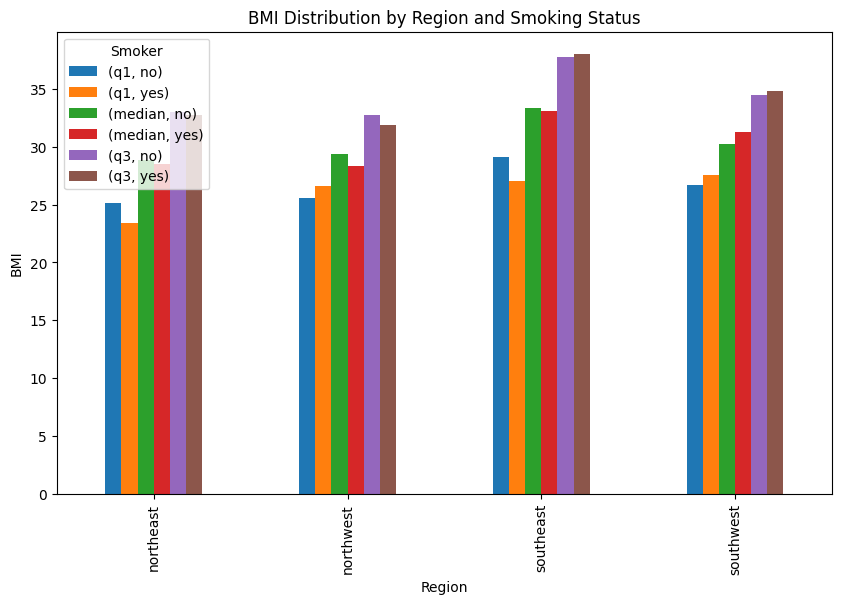

In [ ]:
bmi_region_smoker_pd = bmi_region_smoker_stats.toPandas()

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bmi_region_smoker_pd.pivot(index='region', columns='smoker', values=['q1', 'median', 'q3']).plot(kind='bar', ax=ax)


plt.title('BMI Distribution by Region and Smoking Status')
plt.xlabel('Region')
plt.ylabel('BMI')
plt.legend(title='Smoker')

plt.show()

The grouped bar plot presents BMI distribution across regions, separating smokers from non-smokers. It offers a straightforward comparison of BMI quartiles in each region and among different smoking groups. This visualization helps identify potential regional differences in BMI and the influence of smoking on BMI distribution, aiding in healthcare planning and targeted interventions.

## Predict Insurance Charges with Linear Regression

In [ ]:
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Index categorical variables
indexer_sex = StringIndexer(inputCol='sex', outputCol='sex_indexed')
indexer_smoker = StringIndexer(inputCol='smoker', outputCol='smoker_indexed')
indexer_region = StringIndexer(inputCol='region', outputCol='region_indexed')

# Assemble all features into a single vector
assembler = VectorAssembler(inputCols=['sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed'],
                            outputCol='features')


# Create feature engineering pipeline
fe_pipe = Pipeline(stages=[indexer_sex, indexer_smoker, indexer_region, assembler])

# Apply the pipeline to the insurance dataset
insurance_fe = fe_pipe.fit(insurance).transform(insurance)

# Show the transformed dataset
insurance_fe.show(5)

+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|smoker_indexed|region_indexed|            features|
+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|           1.0|           2.0|[1.0,27.9,0.0,1.0...|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|           0.0|           0.0|(5,[1,2],[33.77,1...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|           0.0|           0.0|(5,[1,2],[33.0,3.0])|
| 33|  male|22.705|       0|    no|northwest|21984.47061|        0.0|           0.0|           1.0|(5,[1,4],[22.705,...|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|        0.0|           0.0|           1.0|(5,[1,4],[28.88,1...|
+---+------+------+--------+----

Steps Explained

1. Indexing Categorical Variables: StringIndexer converts categorical variables ('sex', 'smoker', 'region') into numerical indices. This is necessary because most machine learning algorithms require numerical inputs.

2. Assembling Features: VectorAssembler combines all feature columns into a single vector. This is required by Spark's machine learning algorithms.

3. Scaling Numerical Features: StandardScaler standardizes numerical features by subtracting the mean and dividing by the standard deviation. This ensures that all features are on a similar scale, preventing some features from dominating the model due to their larger magnitude.

4. Pipeline: Finally, the pipeline defines the order of the aforementioned steps.



In [ ]:
# do not modify
display(insurance_fe.show(10))

+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|smoker_indexed|region_indexed|            features|
+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|           1.0|           2.0|[1.0,27.9,0.0,1.0...|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|           0.0|           0.0|(5,[1,2],[33.77,1...|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|           0.0|           0.0|(5,[1,2],[33.0,3.0])|
| 33|  male|22.705|       0|    no|northwest|21984.47061|        0.0|           0.0|           1.0|(5,[1,4],[22.705,...|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|        0.0|           0.0|           1.0|(5,[1,4],[28.88,1...|
| 31|female| 25.74|       0|    

None

In [ ]:
#Pipeline after feature engineering.

from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

lr = LinearRegression(featuresCol='features', labelCol='charges')

# linear regression pipeline
lr_pipe = Pipeline(stages=[fe_pipe, lr])

# Split the data into train and test sets
train_data, test_data = insurance.randomSplit([0.8, 0.2], seed=42)

# Train the linear regression pipeline
lr_model = lr_pipe.fit(train_data)

# Make predictions on the test data
predictions = lr_model.transform(test_data)

# Evaluate the model using Mean Squared Error (MSE)
evaluator = RegressionEvaluator(labelCol='charges', predictionCol='prediction', metricName='mse')
lr_test_mse = evaluator.evaluate(predictions)
print("Linear Regression Test MSE:", lr_test_mse)

Linear Regression Test MSE: 46995772.54339414


In [ ]:
# do not modify
print(f'Linear regression test MSE: {lr_test_mse:.0f}')

Linear regression test MSE: 46995773


Inference on the linear regression prediction model

In [ ]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)

# Define Linear Regression model
lr = LinearRegression(featuresCol='scaled_features', labelCol='charges')

# Create linear regression pipeline
lr_pipe_inf = Pipeline(stages=[fe_pipe, scaler, lr])

# Split the data into train and test sets
train_data, test_data = insurance.randomSplit([0.8, 0.2], seed=42)

# Train the linear regression pipeline
lr_model2 = lr_pipe_inf.fit(train_data)

# Make predictions on the test data
predictions = lr_model2.transform(test_data)

# Evaluate the model using Mean Squared Error (MSE)
evaluator = RegressionEvaluator(labelCol='charges', predictionCol='prediction', metricName='mse')
lr_test_mse = evaluator.evaluate(predictions)
print("Linear Regression Test MSE:", lr_test_mse)

Linear Regression Test MSE: 46995772.54339439


*The MSEs are equal in both models indicating that the scaling process didn't have an effect on the performance of the linear regression model in terms of MSE. This could because of how the features were naturally on a similar scale*

## Classification of High/Low Charges with Logistic Regression

In [ ]:
# your code here

from pyspark.sql.functions import when

# Calculate the median of the charges column
charges_median = insurance_fe.approxQuantile("charges", [0.5], 0.01)[0]

# Add the rate_pool column based on stratification
insurance_stratified = insurance_fe.withColumn("rate_pool",
                                               when(insurance_fe["charges"] > charges_median, 1).otherwise(0))

# Show the resulting DataFrame
insurance_stratified.show(5)

+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+---------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|smoker_indexed|region_indexed|            features|rate_pool|
+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+---------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|        1.0|           1.0|           2.0|[1.0,27.9,0.0,1.0...|        1|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|        0.0|           0.0|           0.0|(5,[1,2],[33.77,1...|        0|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|        0.0|           0.0|           0.0|(5,[1,2],[33.0,3.0])|        0|
| 33|  male|22.705|       0|    no|northwest|21984.47061|        0.0|           0.0|           1.0|(5,[1,4],[22.705,...|        1|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|        0.0|           0.0

In [ ]:
# do not modify
insurance_stratified.select('charges', 'rate_pool').show(10)

+-----------+---------+
|    charges|rate_pool|
+-----------+---------+
|  16884.924|        1|
|  1725.5523|        0|
|   4449.462|        0|
|21984.47061|        1|
|  3866.8552|        0|
|  3756.6216|        0|
|  8240.5896|        0|
|  7281.5056|        0|
|  6406.4107|        0|
|28923.13692|        1|
+-----------+---------+
only showing top 10 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

training, testing = insurance_stratified.randomSplit([0.5, 0.5], seed = 1870)

# combine the input columns into a single vector
va = VectorAssembler(inputCols=['sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed'],
                            outputCol='features2')

# initialize the logistic regression model
log_reg = LogisticRegression(featuresCol = 'features2',
                             labelCol = 'rate_pool')

# set up the pipeline
log_reg_pipe = Pipeline(stages=[va, log_reg])

# train the model
log_reg_model = log_reg_pipe.fit(training)

In [ ]:
predictions = log_reg_model.transform(testing)
predictions.show(15)

+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
|age|   sex|   bmi|children|smoker|   region|    charges|sex_indexed|smoker_indexed|region_indexed|            features|rate_pool|           features2|       rawPrediction|         probability|prediction|
+---+------+------+--------+------+---------+-----------+-----------+--------------+--------------+--------------------+---------+--------------------+--------------------+--------------------+----------+
| 18|female| 25.08|       0|    no|northeast|  2196.4732|        1.0|           0.0|           3.0|[1.0,25.08,0.0,0....|        0|[1.0,25.08,0.0,0....|[0.50235154173646...|[0.62301179289332...|       0.0|
| 18|female|26.315|       0|    no|northeast| 2198.18985|        1.0|           0.0|           3.0|[1.0,26.315,0.0,0...|        0|[1.0,26.315,0.0,0...|[0.44637097893645...|[0.60977

In [ ]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol = 'rawPrediction',
                                          labelCol = 'rate_pool')

roc_auc_log_reg = evaluator.evaluate(predictions)

print(f'Area Under ROC Curve for Logistic Regression: {roc_auc_log_reg:.2f}')

Area Under ROC Curve for Logistic Regression: 0.73


In [ ]:
import numpy as np
import pandas as pd

# Extract coefficients and intercept from the logistic regression model
coefficients = log_reg_model.stages[-1].coefficients.toArray()
intercept = log_reg_model.stages[-1].intercept

# Extract feature names
features = ['sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed']

# Create a DataFrame to store coefficients
coefficients_df = pd.DataFrame({'feature2': features, 'coefficient': coefficients})

# Print intercept and coefficients
print("Intercept:", intercept)
print("Coefficients:")
print(coefficients_df)

# Extract the first observation from the test data
first_observation = testing.select('sex_indexed', 'bmi', 'children', 'smoker_indexed', 'region_indexed').head()

# Calculate the linear combination of features and coefficients
linear_combination = np.dot(coefficients, first_observation)

# Calculate the probability of rate_pool being 1 (charged greater than median)
probability_rate_pool_1 = np.exp(intercept + linear_combination) / (1 + np.exp(intercept + linear_combination))

# Print the calculated probability
print("Probability of rate_pool being 1 (charged greater than median):", probability_rate_pool_1)



Intercept: -2.459745941023183
Coefficients:
         feature2  coefficient
0     sex_indexed     0.143011
1             bmi     0.045328
2        children     0.107605
3  smoker_indexed    23.505569
4  region_indexed     0.225849
Probability of rate_pool being 1 (charged greater than median): 0.37698820710667497


In [ ]:
# linear combination of features and coefficients
linear_combination = intercept + np.dot(coefficients, first_observation)

# Apply the logistic function to obtain the probability
probability = 1 / (1 + np.exp(-linear_combination))

# Calculated probability
print("Probability of rate_pool being 1:", probability)

# Make the prediction based on the probability
prediction = 1 if probability >= 0.5 else 0

# The prediction
print("Prediction for rate_pool:", prediction)



Probability of rate_pool being 1: 0.37698820710667497
Prediction for rate_pool: 0


In [ ]:
#No, the prediction is wrong. The actual value is 1.